In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from deluca.agents import BPC, LQR, EBPC
from deluca.envs import LDS
import jax.numpy as jnp
import jax
import numpy as np

from jax.config import config
config.update("jax_debug_nans", True)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/stephen/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [3]:
PRINT_RATE = 10000
def get_loss(T, lds, controller, noise, random_key=jax.random.PRNGKey(42)):
    lds.reset()
    avg_loss = 0
    loss = 0
    loss_list = []
    prev_noise = jnp.zeros(shape=lds.state.shape)
    key = random_key
    last_avg_loss = 0
    for i in range(T):

        key, subkey = jax.random.split(key)
        try:
            action = controller(lds.obs, loss)
        except:
            action = controller(lds.obs)
        lds.step(action)
        if noise == "Gaussian":
            lds.state += 0.03 * jax.random.normal(subkey, shape=lds.state.shape)
        elif noise == "Sinusoidal":
            lds.state += 0.03 * jnp.sin(i/(20 * np.pi))
        elif noise == "GaussianWalk":
            prev_noise = prev_noise + jax.random.normal(subkey, shape=lds.state.shape)
            lds.state += .1 * prev_noise / np.sqrt(T)
        elif noise == "None":
            pass
        else:
            raise ValueError("Noise type unrecognized!")
        loss = (jnp.linalg.norm(lds.state)**2+jnp.linalg.norm(action)**2)
        last_avg_loss += loss
        if (i+1) % PRINT_RATE == 0:
            print(str(i+1) + " avg loss:", last_avg_loss/PRINT_RATE)
            last_avg_loss = 0
        avg_loss += loss/T
        loss_list += [loss]
    return np.array(loss_list)

def mavg(data, period=1000):
    recent_sum = np.cumsum(data)
    recent_sum[period:] -= recent_sum[:-period]
    norm = np.cumsum(np.ones(data.shape))
    norm[period:] -= norm[:-period]
    return recent_sum / norm


In [4]:
T = 100000  # 100000

system = "DI" # one of "DI", "LargeSparse"
noise = "GaussianWalk" # one of "Gaussian", "GaussianWalk", "Sinusoidal", "None"

if system == "DI":
    A = jnp.array([[.9, .9], [-0.01, .9]])
    B = jnp.array([[0], [1]])
elif system == "LargeSparse":
    A = jnp.array([[.3, 0, 0, .4, .1], [0, .5, .5, .5, 0], [.05, .05, .05, .05, 0], [.3, 0, 0, 0, 0], [4, 0, 0, 0, .1]])
    B = jnp.array([[2, 0, 0], [0, .3, .1], [0, .1, .3], [0, 0, 0], [0, 0, 0]])
else:
    raise ValueError("System type unrecognized!")
#A,B = jnp.array([[.8,.5], [0,.8]]), jnp.array([[0],[0.8]])

use_K = True


In [5]:
bpc = BPC(A, B, lr_scale=10, delta=1e-3, decay=True, use_K=use_K)
bpc_losses = get_loss(T, LDS(state_size= B.shape[0], action_size=B.shape[1], A=A, B=B), bpc, noise)

In [ ]:
lqr = LQR(A, B)
lqr_losses = get_loss(T, LDS(state_size= B.shape[0], action_size=B.shape[1], A=A, B=B), lqr, noise)

In [ ]:
ebpc = EBPC(
    A = A,
    B = B,
    C = None,
    T = T,
    H = 5,   # To change, but good for debug
    cost_bound = 1e5,
    rad = 3,
    beta = 5.0,
    sigma = 0.2,
    eta_mul = 3e7,  # 3e6 (or 3e7?)
    grad_mul = 3e-5, # 3e-4, 3e-5 Typically wants to decrease as eta_mul increases to offset its effect
    use_K=True,
)
ebpc_losses = get_loss(T, LDS(state_size=B.shape[0], action_size=B.shape[1], A=A, B=B), ebpc, noise)

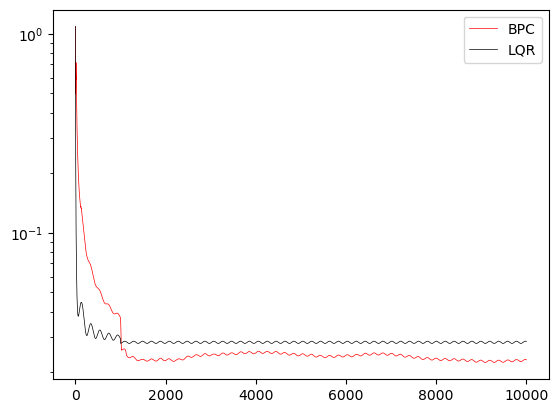

In [27]:
import matplotlib.pyplot as plt
colors = {"BPC": "red", "LQR": "black", "EBPC": "blue"}
plt.plot(mavg(bpc_losses), label="BPC", color=colors["BPC"], linewidth=0.5)
plt.plot(mavg(lqr_losses), label="LQR", color=colors["LQR"], linewidth=0.5)
#plt.plot(mavg(ebpc_losses), label="$\\bf{EBPC}$", color=colors["EBPC"], linewidth=0.5)
plt.legend()
plt.yscale('log')
plt.show()
#plt.savefig(system + "_" + noise + ".png")

## To work, these next functions need to be imported, instead of defined here. Alternately, you can remove the Multiprocessing part.

In [5]:
from deluca.agents import loss_info
from deluca.agents._lqr import LQR
from deluca.agents._bpc import BPC
from deluca.envs import LDS

# For testing. This is the wrong place. 

def get_loss(T, lds, controller, noise, random_key=jax.random.PRNGKey(42)):
    PRINT_RATE = 10000
    lds.reset()
    avg_loss = 0
    loss = 0
    loss_list = []
    prev_noise = jnp.zeros(shape=lds.state.shape)
    key = random_key
    last_avg_loss = 0
    for i in range(T):

        key, subkey = jax.random.split(key)
        try:
            action = controller(lds.obs, loss)
        except:
            action = controller(lds.obs)
        lds.step(action)
        if noise == "Gaussian":
            lds.state += 0.03 * jax.random.normal(subkey, shape=lds.state.shape)
        elif noise == "Sinusoidal":
            lds.state += 0.03 * jnp.sin(i/(20 * np.pi))
        elif noise == "GaussianWalk":
            prev_noise = prev_noise + jax.random.normal(subkey, shape=lds.state.shape)
            lds.state += .1 * prev_noise / np.sqrt(T)
        elif noise == "None":
            pass
        else:
            raise ValueError("Noise type unrecognized!")
        loss = (jnp.linalg.norm(lds.state)**2+jnp.linalg.norm(action)**2)
        last_avg_loss += loss
        if (i+1) % PRINT_RATE == 0:
            print(str(i+1) + " avg loss:", last_avg_loss/PRINT_RATE)
            last_avg_loss = 0
        avg_loss += loss/T
        loss_list += [loss]
    return np.array(loss_list)

def give_controller(c, T, A, B, use_K, rkey):
    if c == 'BPC':
        return BPC(A, B, lr_scale=10, delta=1e-3, decay=True, use_K=use_K)
    elif c == 'LQR':
        return LQR(A, B)
    elif c == 'EBPC':
        return EBPC(
            A = A,
            B = B,
            C = None,
            T = T,
            H = 5,   # To change, but good for debug
            cost_bound = 1e5,
            rad = 3,
            beta = 5.0,
            sigma = 0.2,
            eta_mul = 3e7,  # 3e6 (or 3e7?)
            grad_mul = 3e-5, # 3e-4, Typically wants to decrease as eta_mul increases to offset its effect
            use_K=True,
            random_key=jax.random.PRNGKey(rkey+42),
        )

def loss_info(T, A, B, use_k, controller, noise, keyval):
    return get_loss(T, 
                    LDS(state_size= B.shape[0], action_size=B.shape[1], A=A, B=B), 
                    give_controller(controller, T, A, B, use_k, keyval), 
                    noise,
                    jax.random.PRNGKey(keyval+42))


In [6]:
import os
os.environ["XLA_FLAGS"] = ("--xla_cpu_multi_thread_eigen=false "
                           "intra_op_parallelism_threads=1")
from multiprocessing import get_context

n = 6
def give_controller(c, n):
    if c == 'BPC':
        return BPC(A, B, lr_scale=1e1, delta=1e-3, decay=True, use_K=use_K)
    elif c == 'LQR':
        return LQR(A, B)
    elif c == 'EBPC':
        return EBPC(
            A = A,
            B = B,
            C = None,
            T = T,
            H = 5,   # To change, but good for debug
            cost_bound = 1e5,
            rad = 3,
            beta = 5.0,
            sigma = 0.2,
            eta_mul = 3e7,  # 3e6 (or 3e7?)
            grad_mul = 3e-5, # 3e-4, Typically wants to decrease as eta_mul increases to offset its effect
            use_K=True,
            random_key=jax.random.PRNGKey(n+42),
        )
    
controllers = ['LQR', 'BPC', 'EBPC']

from deluca.agents import loss_info

results = {}
for c in controllers:
    # def loss_info(seed):
    #     return get_loss(T, 
    #                     LDS(state_size= B.shape[0], action_size=B.shape[1], A=A, B=B), 
    #                     give_controller(c, seed), 
    #                     noise, 
    #                     random_key=jax.random.PRNGKey(seed+42))
    with get_context("spawn").Pool() as pool:
        losses = pool.starmap(loss_info, [(T, A, B, True, c, noise, i) for i in range(n)])
    losses = np.array(losses)
    mean = np.average(losses, axis=0)
    std_dev = np.sqrt(np.average(np.square(losses - mean), axis=0))
    results[c] = (mean, std_dev)
    print("Finished controller", c)
    # losses = []
    # for i in range(n):
    #     losses += [get_loss(T, 
    #                         LDS(state_size= B.shape[0], action_size=B.shape[1], A=A, B=B), 
    #                         give_controller(c, i), 
    #                         noise, 
    #                         random_key=jax.random.PRNGKey(i+42))]
    #     print("Finished iteration", i, "of", c)
    # losses = np.array(losses)
    # mean = np.average(losses, axis=0)
    # std_dev = np.sqrt(np.average(np.square(losses - mean), axis=0))
    # results[c] = (mean, std_dev)



No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/stephen/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/stephen/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/stephen/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box 

10000 avg loss: 0.014325667005663139
10000 avg loss: 0.014830059441176695
10000 avg loss: 0.021503343539429464
10000 avg loss: 0.06045074715861135
10000 avg loss: 0.006140387893758642
10000 avg loss: 0.00998051235872161
20000 avg loss: 0.09718447366744458
20000 avg loss: 0.0153030423678827
20000 avg loss: 0.18118672719585974
20000 avg loss: 0.05468487028576163
20000 avg loss: 0.030610237502050386
20000 avg loss: 0.04820293059951986
30000 avg loss: 0.06643647248452111
30000 avg loss: 0.02506426131933777
30000 avg loss: 0.21087637892754038
30000 avg loss: 0.07736966066995538
30000 avg loss: 0.04634960622288965
30000 avg loss: 0.0207043216918459
40000 avg loss: 0.008554380055439926
40000 avg loss: 0.18157281921209809
40000 avg loss: 0.014675833270567474
40000 avg loss: 0.04419470274992776
40000 avg loss: 0.026875318967960818
40000 avg loss: 0.09406736457528006
50000 avg loss: 0.004326720152723253
50000 avg loss: 0.23597490602727003
50000 avg loss: 0.027754511359379296
50000 avg loss: 0.04

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/stephen/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/stephen/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/stephen/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by 

10000 avg loss: 0.010075836519451603
10000 avg loss: 0.019752630473206783
10000 avg loss: 0.004777341615895956
10000 avg loss: 0.009223961628146595
10000 avg loss: 0.020473154632317102
10000 avg loss: 0.04317127373811316
20000 avg loss: 0.2401721358027833
20000 avg loss: 0.02195117859485194
20000 avg loss: 0.12914770041277773
20000 avg loss: 0.032464388660730065
20000 avg loss: 0.03357241927063936
20000 avg loss: 0.018223132403846428
30000 avg loss: 0.10045090963975019
30000 avg loss: 0.035067791964893465
30000 avg loss: 0.17950442472740727
30000 avg loss: 0.014471994993168882
30000 avg loss: 0.05245284660311454
30000 avg loss: 0.029088786850588817
40000 avg loss: 0.06882289069116071
40000 avg loss: 0.022755114038787754
40000 avg loss: 0.15267073799320172
40000 avg loss: 0.010468770830921844
40000 avg loss: 0.07007637209083672
40000 avg loss: 0.009869974381753447
50000 avg loss: 0.07510370076788711
50000 avg loss: 0.032367384765874536
50000 avg loss: 0.02146498946132431
50000 avg loss:

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/stephen/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/stephen/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/stephen/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by 

eta: 12.427578366433574
eta: 12.427578366433574
eta: 12.427578366433574
eta: 12.427578366433574
eta: 12.427578366433574
eta: 12.427578366433574
10000 avg loss: 0.013440059160092147
10000 avg loss: 0.030341576921169258
10000 avg loss: 0.009367998176365053
10000 avg loss: 0.040690309857653664
10000 avg loss: 0.0054913066698187235
10000 avg loss: 0.025495063821058494
20000 avg loss: 0.013248579125781564
20000 avg loss: 0.1524663329388673
20000 avg loss: 0.037995038101352706
20000 avg loss: 0.20054916409422974
20000 avg loss: 0.027746563574613123
20000 avg loss: 0.019360292588740703
30000 avg loss: 0.020651194615839565
30000 avg loss: 0.07301511636948303
30000 avg loss: 0.013056123426579436
30000 avg loss: 0.24212639190028099
30000 avg loss: 0.034272068602332686
30000 avg loss: 0.025472869436139422
40000 avg loss: 0.006339966332368904
40000 avg loss: 0.044762255053649745
40000 avg loss: 0.05829978117469334
40000 avg loss: 0.18231060292617488
40000 avg loss: 0.005403089916072908
40000 avg l

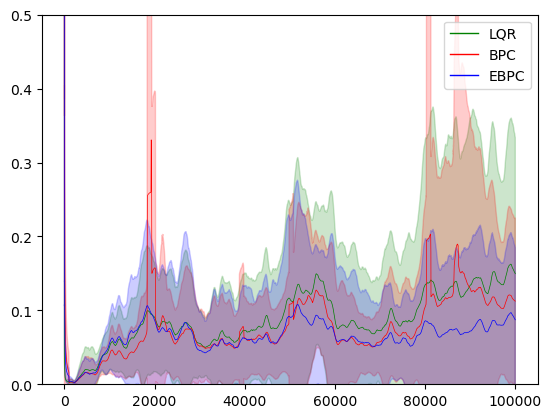

In [7]:
# NOTE: PREVIOUS PLOTS GENERATED WITH LR=1 FOR THE BPC. TRYING 10 NOW. 10 TOO HIGH.

colors = {"BPC": "red", "LQR": "green", "EBPC": "blue"}
for c in controllers:
    x = np.arange(results[c][0].shape[0])
    plt.plot(x, mavg(results[c][0]), color=colors[c], linewidth=0.5)
    plt.fill_between(x, mavg(results[c][0])-mavg(results[c][1]), mavg(results[c][0]) +  mavg(results[c][1]), color=colors[c], alpha=0.2)

plt.legend([Line2D([0], [0], color=colors[c], lw=1) for c in controllers], controllers)
plt.ylim((0, .5))
plt.savefig(str(T) + "_" + system + "_" + noise + "_error_" + str(n) + ".png", dpi=400)

In [ ]:
results['BPC'][1][:100]